### Generating datasets of MCS feature-env 
- extract environmental variables 

In [1]:
!date

Thu Jun  1 23:29:55 PDT 2023


In [2]:
import sys
import os
from pathlib import Path
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.font_manager
from datetime import datetime, timedelta
from glob import glob
import matplotlib.ticker as mticker
import pandas as pd

import scipy.stats
from scipy import interpolate

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
FLEX_DIR = Path(os.getenv('PyFLEX_DATA_DIR'))
case_id = 'imerge_tropics_2014'
DATA_DIR = FLEX_DIR / case_id / 'stats'
GPM_DIR = FLEX_DIR / case_id / 'input/precip/nc_converted'
MCSID_DIR = FLEX_DIR / case_id / 'mcstracking/20140101.0000_20141231.0000'
DIAG_DIR = DATA_DIR /'diagnostics'

In [5]:
def coordinates_processors(data):
    """ 
    converting longitude/latitude into lon/lat 
    data: xarray.dataset coordinated horizontally in lat/lon
    """

    coord_names = []
    for coord_name in data.coords:
        coord_names.append(coord_name)

    if (set(coord_names) & set(['longitude','latitude'])): # if coordinates set this way...

        data2 = data.rename({'latitude': 'lat'})
        data2 = data2.rename({'longitude': 'lon'})
    else:
        data2 = data

    # check if latitutde is decreasing
    if (data2.lat[1] - data2.lat[0]) < 0:
        data2 = data2.isel(lat=slice(None, None, -1)) # flipping latitude accoordingly

    return data2

### load ERA5, GPM data to save environmental variables

In [6]:
# vapor-related data for mapping and diagnostics
ERA5_dir = Path('/neelin2020/ERA-5_cwv_That')
yr=2014
files = sorted(list(ERA5_dir.glob('**/*{}_0[1-9]_*.nc'.format(yr)))) + sorted(list(ERA5_dir.glob('**/*{}_1[0-2]_*.nc'.format(yr))))

data_merged = xr.open_mfdataset(files, engine='netcdf4')
lon_reset = data_merged.lon
lon_reset = lon_reset.where(lon_reset < 180, lon_reset-360) # converting lon as -180 to 180
data_merged.coords['lon'] = lon_reset # converting lon as -180 to 180
data_re = data_merged.sortby('lon')

cwv_data = data_re.cwv.sel(lat=slice(-30,30)) # column water vapor
wv_lft_data = data_re.wv_lft.sel(lat=slice(-30,30)) # Average moisture from 500 mb to 900 mb
wv_bl_data = data_re.wv_bl.sel(lat=slice(-30,30)) # Average moisture from 900 mb to surface

In [7]:
# 3-D data
# ERA5 t, q, u, v
ta_data = xr.open_dataset(DIAG_DIR / 'ERA5_ta_3hrly.nc')
ta_data = coordinates_processors(ta_data)
q_data = xr.open_dataset(DIAG_DIR / 'ERA5_q_3hrly.nc')
q_data = coordinates_processors(q_data)
u_data = xr.open_dataset(DIAG_DIR / 'ERA5_u_3hrly.nc')
u_data = coordinates_processors(u_data)
v_data = xr.open_dataset(DIAG_DIR / 'ERA5_v_3hrly.nc')
v_data = coordinates_processors(v_data)

omega_data = xr.open_dataset(DIAG_DIR / 'ERA5_omega_3hrly.nc')
omega_data = coordinates_processors(omega_data)

# 2-D data
#ERA5 Buoyancy estimates
BL_data = xr.open_dataset(DIAG_DIR / 'ERA5_BL_components.nc')

#GPM data
files = list(GPM_DIR.glob('*nc'))
gpm_data = xr.open_mfdataset(files)

#MERGE-IR 
files = list(MCSID_DIR.glob('*tracknumber.nc'))
mcsid_data = xr.open_mfdataset(files)
mcsid_data = mcsid_data.tracknumber

In [29]:
class mesoscale_convection:
    
    feature_data_sources = "GPM-IMERGE, MERGE-IR"
    environmental_data_sources = "ERA-5"
    track_frequency = "hourly"
    env_frequency = "3 hourly"
    __version__ = "1.0beta"
    
    def __init__(self):
        self.track_data = None
        self.env_data = None
    
    def load_track_data(self, file_path):
        self.track_data = xr.open_dataset(file_path)
        
        return self.track_data
    
    def load_env_data(self, data_dict, path_dir=True):
        self.env_data = {}
        
        for data_name, file in data_dict.items():
        
            if path_dir == True: # read from a given directory
                
                self.env_data[data_name] = xr.open_dataset(file)
                
            else: # already read as dataset
                
                self.env_data[data_name] = file
            
    def load_feature_data(self, data_dict, path_dir=True):
        self.feature_data = {}
        
        for data_name, file in data_dict.items():
        
            if path_dir == True: # read from a given directory
                
                self.feature_data[data_name] = xr.open_dataset(file)
                
            else: # already read as dataset
                
                self.feature_data[data_name] = file
            
    def get_track_info(self, track_number):
        
        track_info = self.track_data.sel(tracks=track_number)
        
        return track_info
    
    def get_number(self):
        if self.track_data is not None:
            print('Number of MCSs tracked: {}'.format(len(self.track_data['tracks'])))
            return len(self.track_data['tracks'])
        else:
            raise ValueError("No track data loaded. Please call load_track_data() first.")
    
    def get_environment_vars(self, track_id, var_names, lat_range=10, lon_range=10, p_level=None):
        """
        getting environmental variables from loaded datasets with various horizontal grid spacing (ERA5, GPM)
        
        """
        
        if self.env_data is None:
            raise ValueError("No environmental data loaded. Please call load_env_data() first")
        
        else:
            
            track_info = mc.get_track_info(track_number=track_id)

            lat_cen = track_info.meanlat.values # MCS lat centroid
            lon_cen = track_info.meanlon.values

            # find out when the tracked MCS ends as indicated by NaT
            idx_end = np.where(np.isnat(track_info.base_time.values))[0][0] 

            data_chunk = []
            
            env_var_name = [i for i in mc.env_data.keys()][0] # get environment variable load for lat/lon info
            
            for t in range(idx_end):

                time64 = track_info.base_time[t].values
                timestamp = (time64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
                time_sel = datetime.utcfromtimestamp(timestamp)
                
                # find nearest ERA5 grid for the MCS centroid
                idx_sel = np.argmin(np.abs(mc.env_data[env_var_name].lon.values - lon_cen[t]))
                lon_cen_reset = mc.env_data[env_var_name].lon[idx_sel]
                idx_sel = np.argmin(np.abs(mc.env_data[env_var_name].lat.values - lat_cen[t]))
                lat_cen_reset = mc.env_data[env_var_name].lat[idx_sel]
                
                lat_min = lat_cen_reset - lat_range
                lat_max = lat_cen_reset + lat_range
                lon_min = lon_cen_reset - lon_range
                lon_max = lon_cen_reset + lon_range

                data_var = []
                for var in var_names:
                
                    data_extract = mc.env_data[var].sel(lat=slice(lat_min, lat_max),
                                                        lon=slice(lon_min, lon_max))
                    data_extract = data_extract.sel(time=time_sel, method='nearest')
                    
                    # geolocate into common grids
                    #data_extract = data_extract.interp(lat=lat_cmgrd, lon=lon_cmgrd)

                    if p_level is not None: # for 3-D data ERA5 only, with vertical dim. named "level"

                        data_extract = data_extract.sel(level=p_level)
                            
                    data_var.append(data_extract)
                data_var_tmerged = xr.merge(data_var) # merge variables into one xr.dataset

                data_chunk.append(data_var_tmerged)
                                   
            return data_chunk
        
    def get_feature_vars(self, track_id, var_name, lat_range=10, lon_range=10):
        
        if self.feature_data is None:
            raise ValueError("No feature data loaded. Please call load_feature_data() first")
        
        else:
            track_info = mc.get_track_info(track_number=track_id)

            lat_cen = track_info.meanlat.values # MCS lat centroid
            lon_cen = track_info.meanlon.values

            # find out when the tracked MCS ends as indicated by NaT
            idx_end = np.where(np.isnat(track_info.base_time.values))[0][0] 
            
            data_chunk = []
            
            env_var_name = [i for i in mc.env_data.keys()][0] # get environment variable load for lat/lon info
            
            for t in range(idx_end):

                time64 = track_info.base_time[t].values
                timestamp = (time64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
                time_sel = datetime.utcfromtimestamp(timestamp)
                
                # find nearest ERA5 grid for the MCS centroid
                
                idx_sel = np.argmin(np.abs(mc.env_data[env_var_name].lon.values - lon_cen[t]))
                lon_cen_reset = mc.env_data[env_var_name].lon[idx_sel]
                idx_sel = np.argmin(np.abs(mc.env_data[env_var_name].lat.values - lat_cen[t]))
                lat_cen_reset = mc.env_data[env_var_name].lat[idx_sel]
                
                lat_min = lat_cen_reset - lat_range
                lat_max = lat_cen_reset + lat_range
                lon_min = lon_cen_reset - lon_range
                lon_max = lon_cen_reset + lon_range

                data_mcsid =  mc.feature_data[var_name].sel(time=time_sel, method='nearest')
                data_mcsid = data_mcsid.where(data_mcsid==track_id+1, 0)
                data_mcsid = data_mcsid.interp(lon = mc.env_data[env_var_name].lon, 
                                               lat = mc.env_data[env_var_name].lat) # interpolate into 0.25deg
                data_extract = data_mcsid.sel(lat=slice(lat_min, lat_max),
                                                    lon=slice(lon_min, lon_max))
                data_extract = data_extract.where(data_extract>0, 0) # exclude other MCSs in the scene
                data_extract = data_extract.where(data_extract==0, track_id+1).astype('float32') # fill back the tracknumber 
                    
                data_chunk.append(data_extract)
                
            return data_chunk
        
    def merge_feat_env_datasets(self, MCSfeat_mask, MCStrack_env):
        
        var_merge_list = []
        
        for t in range(len(MCSfeat_mask)):
            
            var_merge_list.append(xr.merge([MCSfeat_mask[t], MCStrack_env[t]], compat='override'))
            
        return var_merge_list

### Application of Mesoscale Convectvie System Class 
- load data
- plot data
- save data 

In [30]:
data_track = xr.open_dataset(DATA_DIR / 'mcs_tracks_pf_20140101.0000_20141231.0000.nc')
meanlat = np.nanmean(data_track.meanlat.values, axis=1)
meanlon = np.nanmean(data_track.meanlon.values, axis=1)
### only for MCSs over oceans
latcond_1 = np.array([meanlat > -20]).squeeze()
latcond_2 = np.array([meanlat < 20]).squeeze()
loncond_1 = np.array([meanlon > 50]).squeeze()
loncond_2 = np.array([meanlat < 180]).squeeze()
idx_oce = np.all([latcond_1, latcond_2, loncond_1, loncond_2], axis=0)

In [48]:
mc = mesoscale_convection()
# Access attribute values
print("Feature data sources:", mc.feature_data_sources)
print("Environmental data sources:", mc.environmental_data_sources)

# Load track data
mc.load_track_data(DATA_DIR / 'mcs_tracks_pf_20140101.0000_20141231.0000.nc')

# Load environment variables, either 2-D or 3-D
vars_dict = {"ta": ta_data , "q": q_data,  "u": u_data, "v": v_data, "omega": omega_data}

mc.load_env_data(vars_dict, path_dir=False) # var_name given as dict
mc.load_feature_data({"tracknumber": mcsid_data}, path_dir=False)

# Get the length of tracknumber
length = mc.get_number()

# Get subset of ERA5 environment data 
MCStrack_env = mc.get_environment_vars(track_id=2, var_names=['ta','q','u','v','omega']
                                       , p_level=[1000,900,800,700,600,500,400,300,200,100])
MCSfeat_mask = mc.get_feature_vars(track_id=2, var_name='tracknumber')

MCSfeat_env_xr = mc.merge_feat_env_datasets(MCSfeat_mask, MCStrack_env)

Feature data sources: GPM-IMERGE, MERGE-IR
Environmental data sources: ERA-5
Number of MCSs tracked: 17304


In [49]:
# the merged environment variables 2D and 3D along the tracked MCS lifetime
MCSfeat_env_xr[0]

<xarray.Dataset>
Dimensions:      (lon: 81, lat: 81, level: 10)
Coordinates:
    time         datetime64[ns] 2014-01-01
  * lon          (lon) float32 117.2 117.5 117.8 118.0 ... 136.8 137.0 137.2
  * lat          (lat) float32 -12.5 -12.25 -12.0 -11.75 ... 6.75 7.0 7.25 7.5
  * level        (level) int32 1000 900 800 700 600 500 400 300 200 100
Data variables:
    tracknumber  (lat, lon) float32 dask.array<chunksize=(81, 81), meta=np.ndarray>
    t            (level, lat, lon) float32 ...
    q            (level, lat, lon) float32 ...
    u            (level, lat, lon) float32 ...
    v            (level, lat, lon) float32 ...
    w            (level, lat, lon) float32 ...

In [51]:
mc.track_data

<xarray.Dataset>
Dimensions:                  (tracks: 17304, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 17300 17301 17302 17303
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/53)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] ...
    end_basetime             (tracks) datetime64[ns] ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    pf_accumrain             (tracks, times, nmaxpf) float32 ...
    pf_accumrainheavy        (tracks, times, nmaxpf) float32 ...
    pf_landfrac              (tracks, times) float32 ...
    total_rain               (tracks, times) float32 ...
    total_heavyrain          (tracks, times) float32 ...
    rainrate_heavyrain       (tracks, times) float32 ...
Attributes: (12/15)
    Title:                  Statistics of each MCS track
    Institution:            Pacific Northwest National Laboratory
    Contact:                Zhe Feng, zhe.feng@pnnl.gov
    Created_on:             Wed Apr 19 05:36:57 2023
    startdate:              20140101.0000
    enddate:                20141231.0000
    ...                     ...
    MCS_duration_hr:        4
    MCS_area_km^2:          40000
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        90

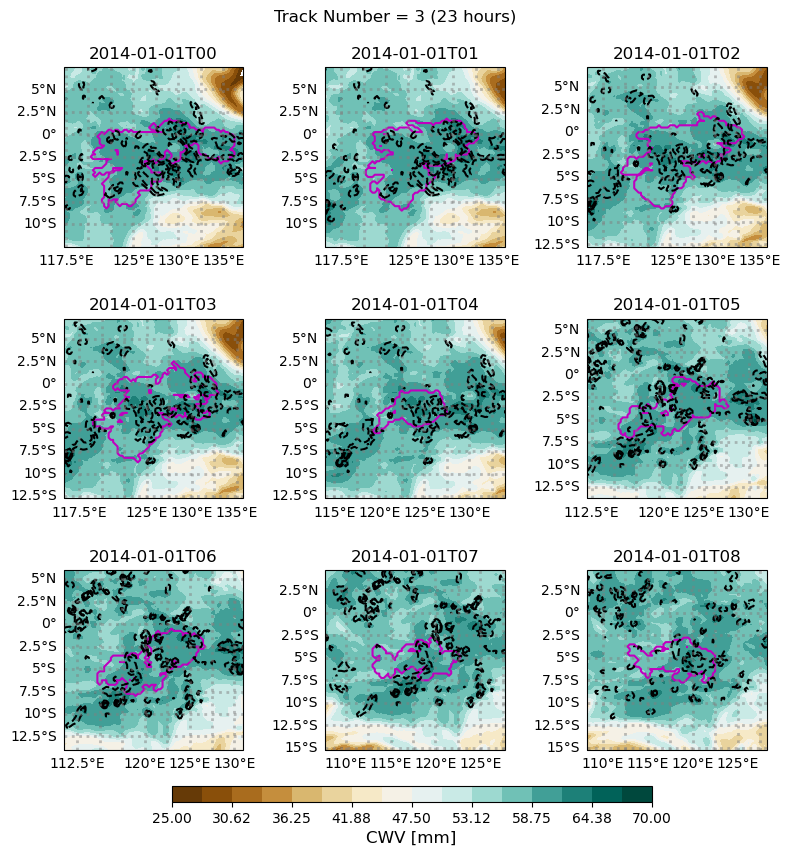

In [57]:
fig = plt.figure(figsize=(8,8))

for n in range(9):
    ax = plt.subplot(3,3,n+1, projection=ccrs.PlateCarree(central_longitude=0))
    
    cwv = -100/9.8*MCSfeat_env_xr[n]['q'].integrate('level')
    
    cf=ax.contourf(MCSfeat_env_xr[n].lon, MCSfeat_env_xr[n].lat, cwv, cmap='BrBG', levels=np.linspace(25,70,17))
    #cf.cmap.set_under('brown')
    #cf.cmap.set_over('darkslategray')
    ax.contour(MCSfeat_env_xr[n].lon, MCSfeat_env_xr[n].lat, MCSfeat_env_xr[n]['tracknumber'], levels=[0,1000], colors=['m'])
    ax.contour(MCSfeat_env_xr[n].lon, MCSfeat_env_xr[n].lat, MCSfeat_env_xr[n]['w'].sel(level=500), levels=[-2,-1,-0.5], colors=['k'])

    ax.set_title(str(MCSfeat_env_xr[n].time.values)[:13])
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # get track number from data itself
    tmp = np.unique(MCSfeat_env_xr[n]['tracknumber'].values) # either 0 or track_id
    track_id = int(np.max(tmp))
    
cbaxes = fig.add_axes([0.22, -0.01, 0.6, 0.02]) 
cbar = plt.colorbar(cf, cax = cbaxes, ax=ax, orientation='horizontal')
cbar.set_label('CWV [mm]',fontsize=12)

plt.suptitle('Track Number = {} ({} hours)'.format(track_id, mc.track_data['mcs_duration'][track_id-1].values))    
plt.tight_layout()

In [54]:
MCSfeat_env_xr[0].w

<xarray.DataArray 'w' (level: 10, lat: 81, lon: 81)>
[65610 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2014-01-01
  * lon      (lon) float32 117.2 117.5 117.8 118.0 ... 136.5 136.8 137.0 137.2
  * lat      (lat) float32 -12.5 -12.25 -12.0 -11.75 -11.5 ... 6.75 7.0 7.25 7.5
  * level    (level) int32 1000 900 800 700 600 500 400 300 200 100
Attributes:
    units:          Pa s**-1
    long_name:      Vertical velocity
    standard_name:  lagrangian_tendency_of_air_pressure

### Save list of xarray.datasets into a pickle file

In [33]:
import pickle

In [44]:
MCS_env_path = '/neelin2020/PyFLEXTRKR_OBS/imerge_tropics_2014/stats/diagnostics/MCS_Env_tmp/MCS_ERA5_Env_track_allvars.pkl'
with open (MCS_env_path, 'wb') as pick:
    pickle.dump(MCSfeat_env_xr, pick)

In [45]:
# load the pickle contents
with open (MCS_env_path,'rb') as pick:
    MCSfeat_env_read = pickle.load(pick)

In [46]:
# MCS-Env data of one tracked MCS 
MCSfeat_env_read[0]

<xarray.Dataset>
Dimensions:      (lon: 81, lat: 81, level: 10)
Coordinates:
    time         datetime64[ns] 2014-01-01
  * lon          (lon) float32 117.2 117.5 117.8 118.0 ... 136.8 137.0 137.2
  * lat          (lat) float32 -12.5 -12.25 -12.0 -11.75 ... 6.75 7.0 7.25 7.5
  * level        (level) int32 1000 900 800 700 600 500 400 300 200 100
Data variables:
    tracknumber  (lat, lon) float32 dask.array<chunksize=(81, 81), meta=np.ndarray>
    t            (level, lat, lon) float32 ...
    q            (level, lat, lon) float32 ...
    u            (level, lat, lon) float32 ...
    v            (level, lat, lon) float32 ...
    w            (level, lat, lon) float32 ...